#  Решение задачи регрессии при помощи пакета `torch`. Метрики.

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Deep Learning with PyTorch (2020) Авторы: Eli Stevens, Luca Antiga, Thomas Viehmann 
* https://pytorch.org/docs/stable/nn.html
* https://pytorch.org/docs/stable/optim.html
* https://github.com/Lightning-AI/torchmetrics
* https://pytorch.org/docs/stable/generated/torch.no_grad.html
* https://pytorch-lightning.readthedocs.io/en/2.1.2/pytorch/ecosystem/metrics.html#torchmetrics

## Задачи для совместного разбора

In [415]:
from torchtyping import TensorType, patch_typeguard
from typeguard import typechecked
import torch as th
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch
from torchmetrics import MeanMetric

from torch.utils.data import DataLoader, TensorDataset, random_split
from torchmetrics import (
    MeanAbsoluteError, 
    MeanAbsolutePercentageError, 
    MeanSquaredError, 
    MeanSquaredLogError,
    R2Score
)
from sklearn.preprocessing import StandardScaler


Scalar = TensorType[()]
patch_typeguard()

1\. Используя реализацию из `torch.nn`, решите задачу регрессии. Для расчета градиентов воспользуйтесь возможностями по автоматическому дифференцированию `torch`. В качестве функции потерь используйте собственную реализацию MSE. Для настройки весов реализуйте пакетный градиентный спуск с использованием `torch.optim.SGD`.

In [418]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5, random_state=42)
X = th.FloatTensor(X)
y = th.FloatTensor(y)

In [420]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size, bias=True)
    
    def forward(self, x):
        return self.linear(x).squeeze()

In [422]:
model = LinearRegressionModel(input_size=4, output_size=1)

In [424]:

criterion = nn.MSELoss()  # Используем собственную реализацию MSE
optimizer = th.optim.SGD(model.parameters(), lr=0.01)

# Обучение модели
losses = []
epochs = 1000

for epoch in range(epochs):
    y_pred = model(X)
    
    loss = criterion(y_pred, y)
    
    optimizer.zero_grad()  
    loss.backward()        
    optimizer.step()       
    
    losses.append(loss.item())
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.6f}')


print(f"\nРезультаты обучения:")
print(f"Истинные коэффициенты: {coef}")
print(f"Обученные веса: {model.linear.weight.data.detach().numpy()[0]}")
print(f"Обученное смещение: {model.linear.bias.data.item():.4f}")
print(f"Истинное смещение: 0.5")

Epoch 0, Loss: 9522.854492
Epoch 100, Loss: 216.857956
Epoch 200, Loss: 6.982502
Epoch 300, Loss: 0.281138
Epoch 400, Loss: 0.012587
Epoch 500, Loss: 0.000590
Epoch 600, Loss: 0.000028
Epoch 700, Loss: 0.000001
Epoch 800, Loss: 0.000000
Epoch 900, Loss: 0.000000

Результаты обучения:
Истинные коэффициенты: [ 5.63754967 86.47223763 27.34070719 41.48195023]
Обученные веса: [ 5.637558 86.47203  27.340784 41.48182 ]
Обученное смещение: 0.5000
Истинное смещение: 0.5


## Задачи для самостоятельного решения

<p class="task" id="1"></p>

1\. Используя реализацию полносвязного слоя из `torch.nn` решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Для создания модели опишите класс `SineModel`.

Предлагаемая архитектура нейронной сети: 
1. Полносвязный слой с 100 нейронами
2. Активация ReLU
3. Полносвязный слой с 1 нейроном

В процессе обучения сохраняйте промежуточные прогнозы моделей. Визуализируйте облако точек и прогнозы модели в начале, середине и после окончания процесса обучения (не обязательно три, можно взять больше промежуточных вариантов).

Выведите график изменения значения функции потерь в процессе обучения. Логику расчета значения функции потерь на уровне эпохи реализуйте самостоятельно.

- [ ] Проверено на семинаре

In [438]:
import torch 

X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size()) 

In [440]:
import torch.nn as nn
class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int = 100, n_out: int = 1) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),  # Полносвязный слой с 100 нейронами
            nn.ELU(),                        # Активация ReLU
            nn.Linear(n_hidden, n_out)        # Полносвязный слой с 1 нейроном
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [442]:
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True) 

model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss() 
optimizer = optim.SGD(model.parameters(), lr=0.01) 

history = []
epochs_to_save = [0, 1000, 3000, 6000, 8000, 9999]  
losses = []

epochs = 10000

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)
    
    if epoch in epochs_to_save:
        with torch.no_grad():
            y_pred_full = model(X)
            history.append((epoch, y_pred_full.clone()))
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Average Loss: {avg_epoch_loss:.6f}')

Epoch 0, Average Loss: 0.372744
Epoch 200, Average Loss: 0.197643
Epoch 400, Average Loss: 0.180666
Epoch 600, Average Loss: 0.194329
Epoch 800, Average Loss: 0.202294
Epoch 1000, Average Loss: 0.193412
Epoch 1200, Average Loss: 0.192537
Epoch 1400, Average Loss: 0.185234
Epoch 1600, Average Loss: 0.183737
Epoch 1800, Average Loss: 0.193242
Epoch 2000, Average Loss: 0.176505
Epoch 2200, Average Loss: 0.170410
Epoch 2400, Average Loss: 0.161152
Epoch 2600, Average Loss: 0.146761
Epoch 2800, Average Loss: 0.157951
Epoch 3000, Average Loss: 0.146738
Epoch 3200, Average Loss: 0.125475
Epoch 3400, Average Loss: 0.115815
Epoch 3600, Average Loss: 0.120983
Epoch 3800, Average Loss: 0.089127
Epoch 4000, Average Loss: 0.087665
Epoch 4200, Average Loss: 0.077130
Epoch 4400, Average Loss: 0.062791
Epoch 4600, Average Loss: 0.051886
Epoch 4800, Average Loss: 0.045365
Epoch 5000, Average Loss: 0.028051
Epoch 5200, Average Loss: 0.020792
Epoch 5400, Average Loss: 0.016981
Epoch 5600, Average Loss: 0

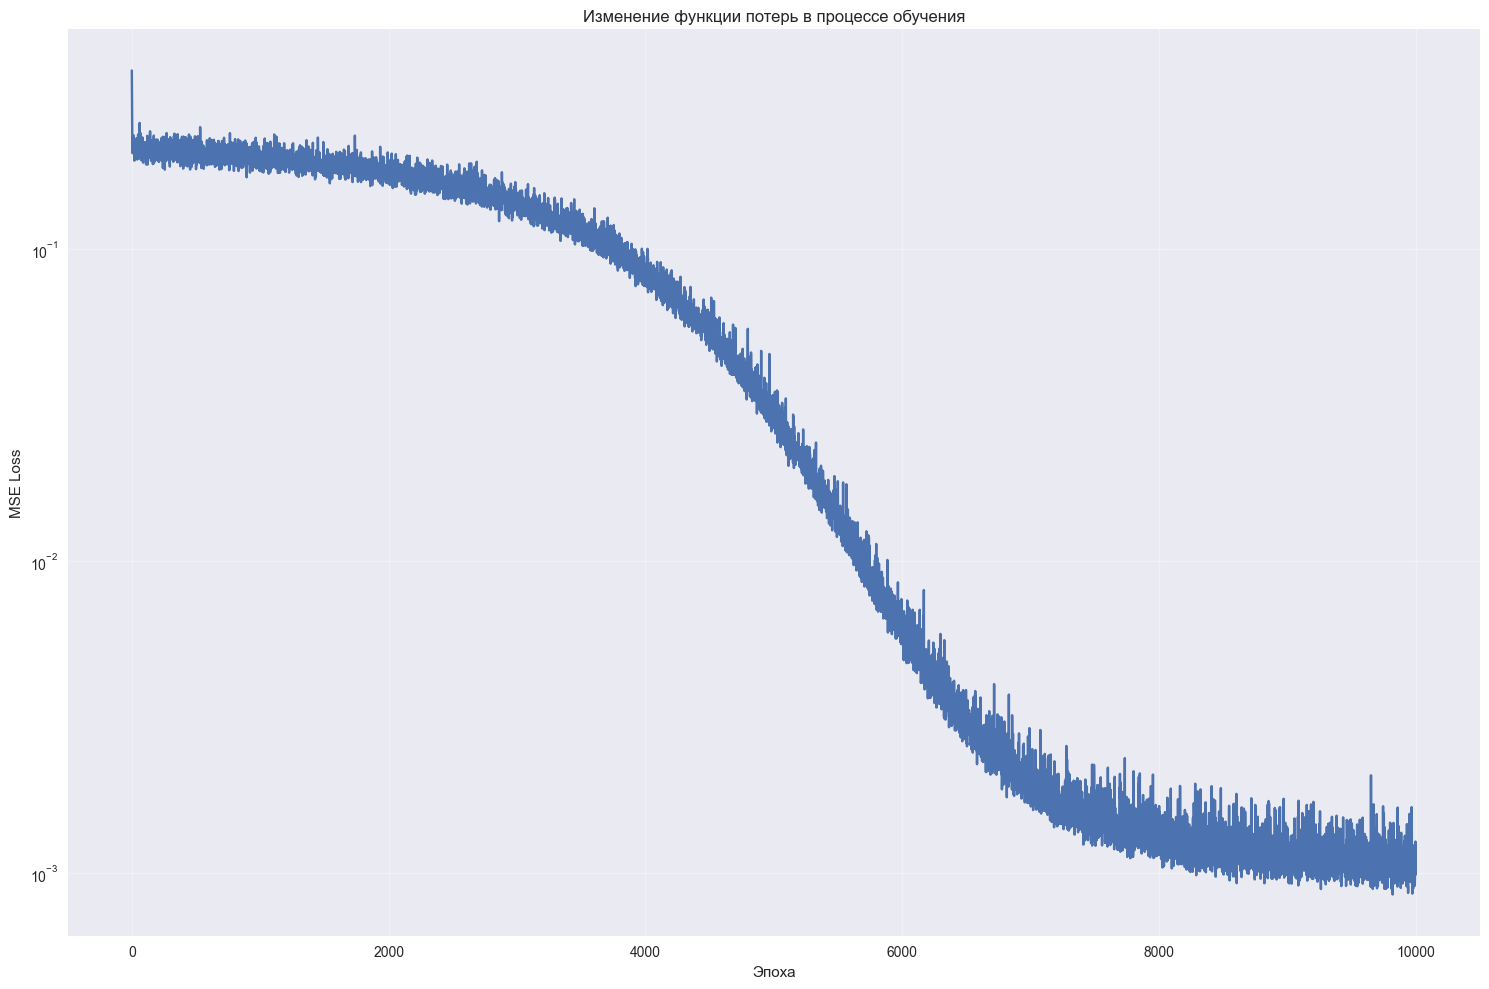

MSE: 0.001187


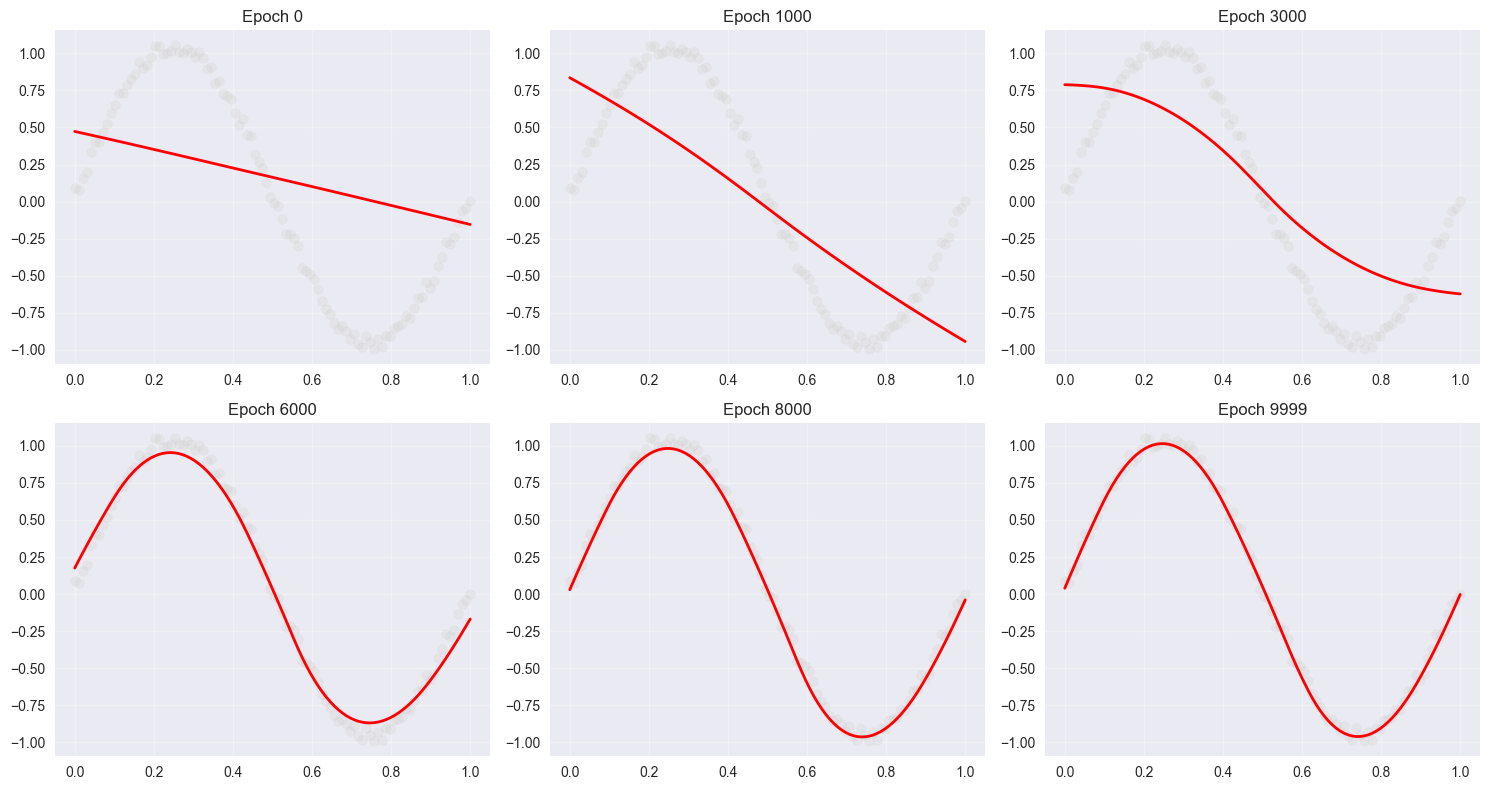

In [444]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.title('Изменение функции потерь в процессе обучения')
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()
plt.show()


final_loss = criterion(model(X), y).item()
print(f"MSE: {final_loss:.6f}")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, (epoch, pred) in enumerate(history):
    axes[idx].scatter(X, y, alpha=0.3, color='lightgray')
    axes[idx].plot(X, pred, 'r-', linewidth=2)
    axes[idx].set_title(f'Epoch {epoch}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<p class="task" id="2"></p>

2\. Повторите решение задачи 1, изменив модель. Для создания модели создайте объект класса `nn.Sequential`.

Предлагаемая архитектура нейронной сети: 
1. Полносвязный слой с 50 нейронами
2. Активация Tanh
3. Полносвязный слой с 1 нейроном

- [ ] Проверено на семинаре

In [318]:
import torch 

X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size()) 

In [320]:
model = nn.Sequential(
    nn.Linear(1, 50),    
    nn.Tanh(),           
    nn.Linear(50, 1)     
)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)  # Мини-пакетный размер 16

criterion = nn.MSELoss()  
optimizer = optim.SGD(model.parameters(), lr=0.01)  

history2 = []
epochs_to_save = [0, 100, 300, 600, 900, 1199]  
losses = []


epochs = 1200

for epoch in range(epochs):
    epoch_loss = 0.0
    batch_count = 0
    
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        batch_count += 1
    
    avg_epoch_loss = epoch_loss / batch_count
    losses.append(avg_epoch_loss)
    
    if epoch in epochs_to_save:
        with torch.no_grad():
            y_pred_full = model(X)
            history2.append((epoch, y_pred_full.clone()))
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, Average Loss: {avg_epoch_loss:.6f}')

Epoch 0, Average Loss: 0.622022
Epoch 200, Average Loss: 0.199332
Epoch 400, Average Loss: 0.192596
Epoch 600, Average Loss: 0.201679
Epoch 800, Average Loss: 0.187900
Epoch 1000, Average Loss: 0.188889


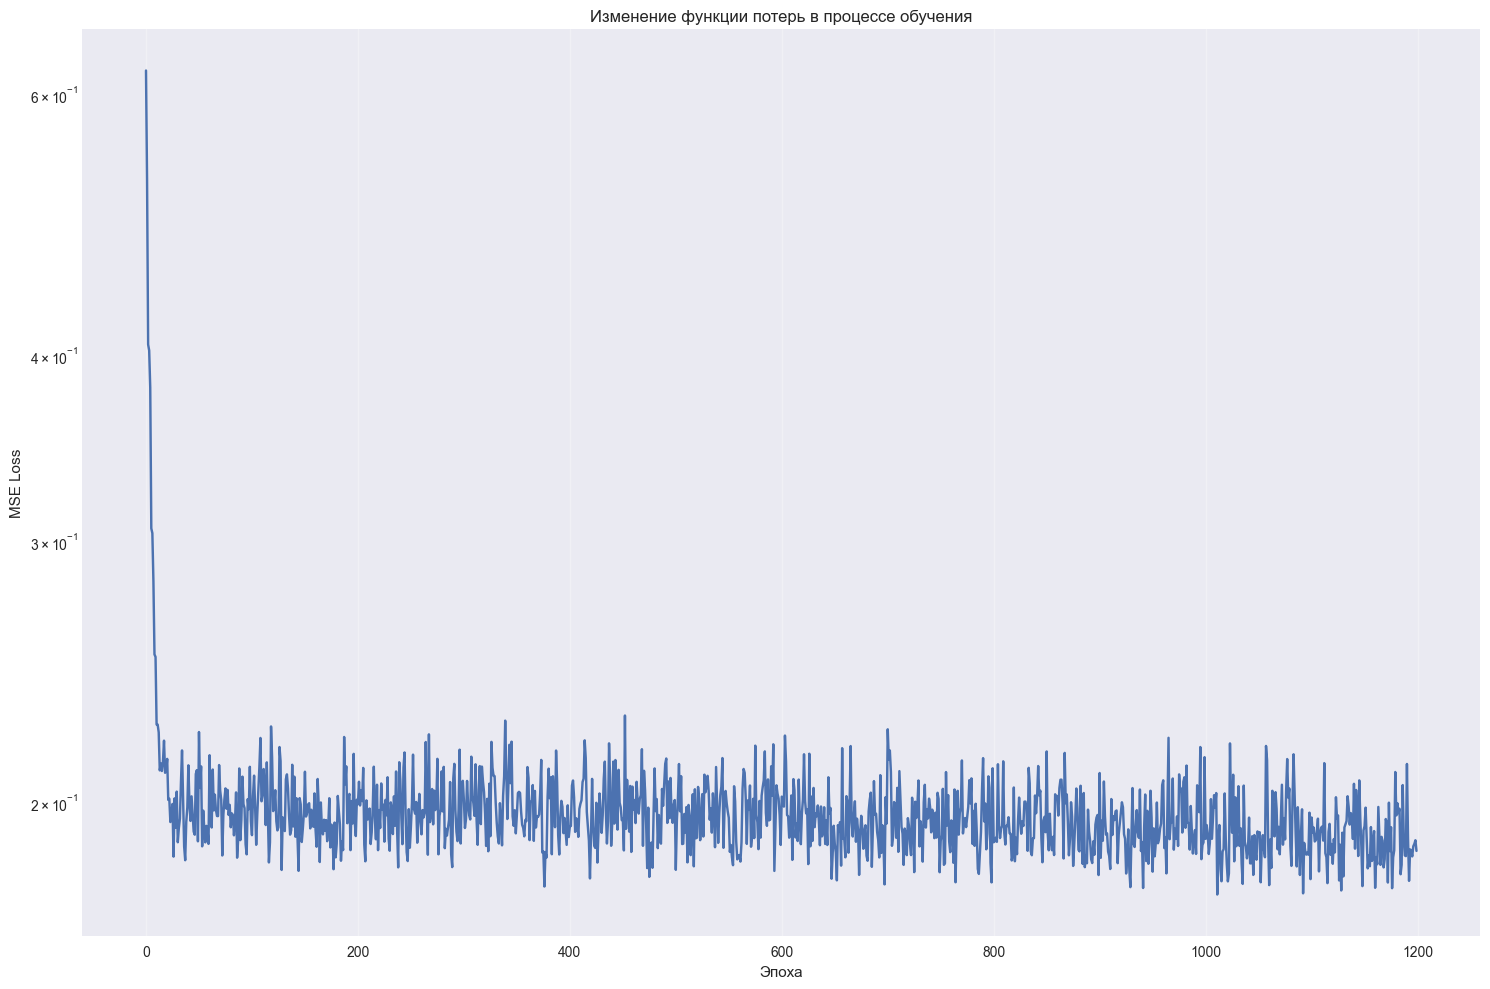

MSE: 0.189080
- Tanh имеет выход в диапазоне [-1, 1], что может быть полезно для аппроксимации синусоиды
- Tanh обеспечивает более плавные переходы по сравнению с ReLU
- Архитектура проще (50 нейронов вместо 100)


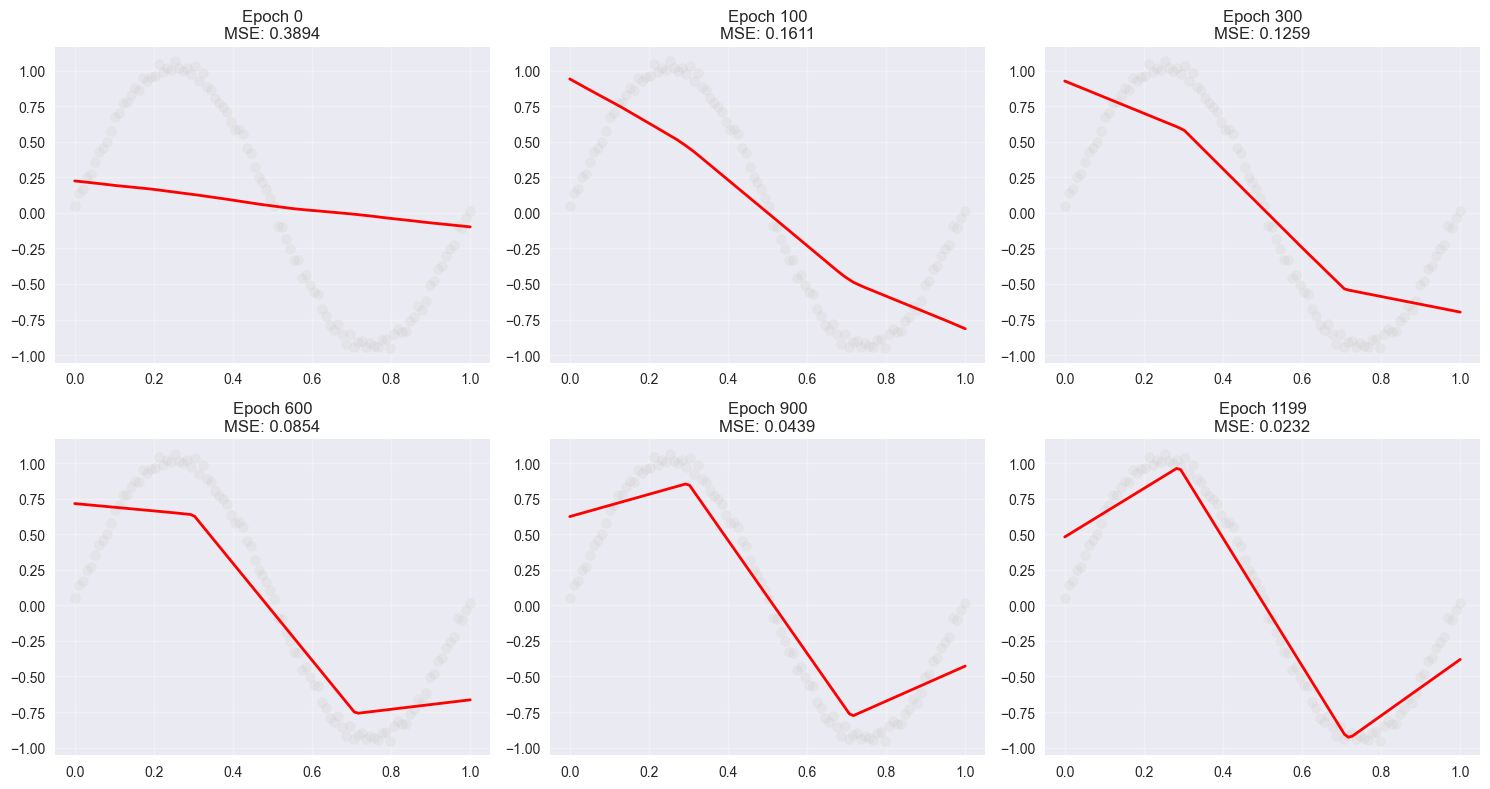

In [321]:
plt.figure(figsize=(15, 10))


plt.plot(losses)
plt.xlabel('Эпоха')
plt.ylabel('MSE Loss')
plt.title('Изменение функции потерь в процессе обучения')
plt.grid(True, alpha=0.3)
plt.yscale('log')



plt.tight_layout()
plt.show()

final_loss = criterion(model(X), y).item()
print(f"MSE: {final_loss:.6f}")

print("- Tanh имеет выход в диапазоне [-1, 1], что может быть полезно для аппроксимации синусоиды")
print("- Tanh обеспечивает более плавные переходы по сравнению с ReLU")
print("- Архитектура проще (50 нейронов вместо 100)")

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

for idx, (epoch, pred) in enumerate(history):
    axes[idx].scatter(X, y, alpha=0.3, color='lightgray')
    axes[idx].plot(X, pred, 'r-', linewidth=2)
    #axes[idx].plot(X, torch.sin(2 * torch.pi * X).numpy(), 'g--', linewidth=1, alpha=0.7)
    axes[idx].set_title(f'Epoch {epoch}\nMSE: {criterion(pred, y).item():.4f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<p class="task" id="3"></p>

3\. Используя реализацию полносвязного слоя из `torch.nn`, решите задачу регрессии. В качестве функции потерь используйте реализацию MSE из `torch.nn`. Для настройки весов реализуйте мини-пакетный градиентный спуск с использованием `torch.optim.SGD`. Перенесите вычисления на GPU и сравните время обучения с и без использования GPU. Решение должно корректно работать в случае отсутствия GPU без дополнительных изменений в коде. 

- [ ] Проверено на семинаре

In [324]:
from sklearn.datasets import make_regression
import torch as th
import time 

X, y, coef = make_regression(
    n_samples=10000, 
    n_features=10, 
    n_informative=6, 
    coef=True, 
    bias=0.5, 
    random_state=42
)
X = th.FloatTensor(X)
y = th.FloatTensor(y).reshape(-1, 1)

In [328]:
class RegressionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
    
    def forward(self, x):
        return self.network(x)

def train_model_on_device(device_name, model_name="Model"):
    device = torch.device(device_name)
    print(f"\n=== Обучение на {device_name.upper()} ===")
    
    model = RegressionModel(input_size=10, hidden_size=128, output_size=1).to(device)
    
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.0001)
    
    losses = []
    start_time = time.time()
    
    epochs = 100
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        for batch_X, batch_y in dataloader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
        
        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        
        if epoch % 20 == 0:
            print(f'Epoch {epoch}, Loss: {avg_loss:.6f}')
    
    training_time = time.time() - start_time
    print(f"Время обучения: {training_time:.2f} секунд")
    
    return model, losses, training_time



devices = ['cpu']

if torch.backends.mps.is_available():
    devices.append('mps')
    
results = {}

for device in devices:
    model, losses, training_time = train_model_on_device(device)
    results[device] = {
        'model': model,
        'losses': losses,
        'training_time': training_time
    }


=== Обучение на CPU ===
Epoch 0, Loss: 18952.433816
Epoch 20, Loss: 4.101871
Epoch 40, Loss: 2.480111
Epoch 60, Loss: 1.761545
Epoch 80, Loss: 1.384522
Время обучения: 4.41 секунд

=== Обучение на MPS ===
Epoch 0, Loss: 18307.934224
Epoch 20, Loss: 4.830562
Epoch 40, Loss: 2.739770
Epoch 60, Loss: 1.824786
Epoch 80, Loss: 1.346089
Время обучения: 17.12 секунд


<p class="task" id="4"></p>

4\. Повторите решение задач 1-2, используя для расчета значения функции потерь за эпоху метрику `MeanMetric` из пакета `torchmetrics`. Добавьте в цикл обучения расчет метрики $R^2$ (воспользуйтесь реализацией из `torchmetrics`). Выведите на экран график изменения значения функции потерь и метрики $R^2$ по эпохам в процессе обучения.

Epoch    0, Loss: 0.474661, R²: 0.0398
Epoch  200, Loss: 0.137722, R²: 0.7070
Epoch  400, Loss: 0.131719, R²: 0.7750
Epoch  600, Loss: 0.067137, R²: 0.8639
Epoch  800, Loss: 0.039313, R²: 0.9163
Epoch 1000, Loss: 0.022234, R²: 0.9541


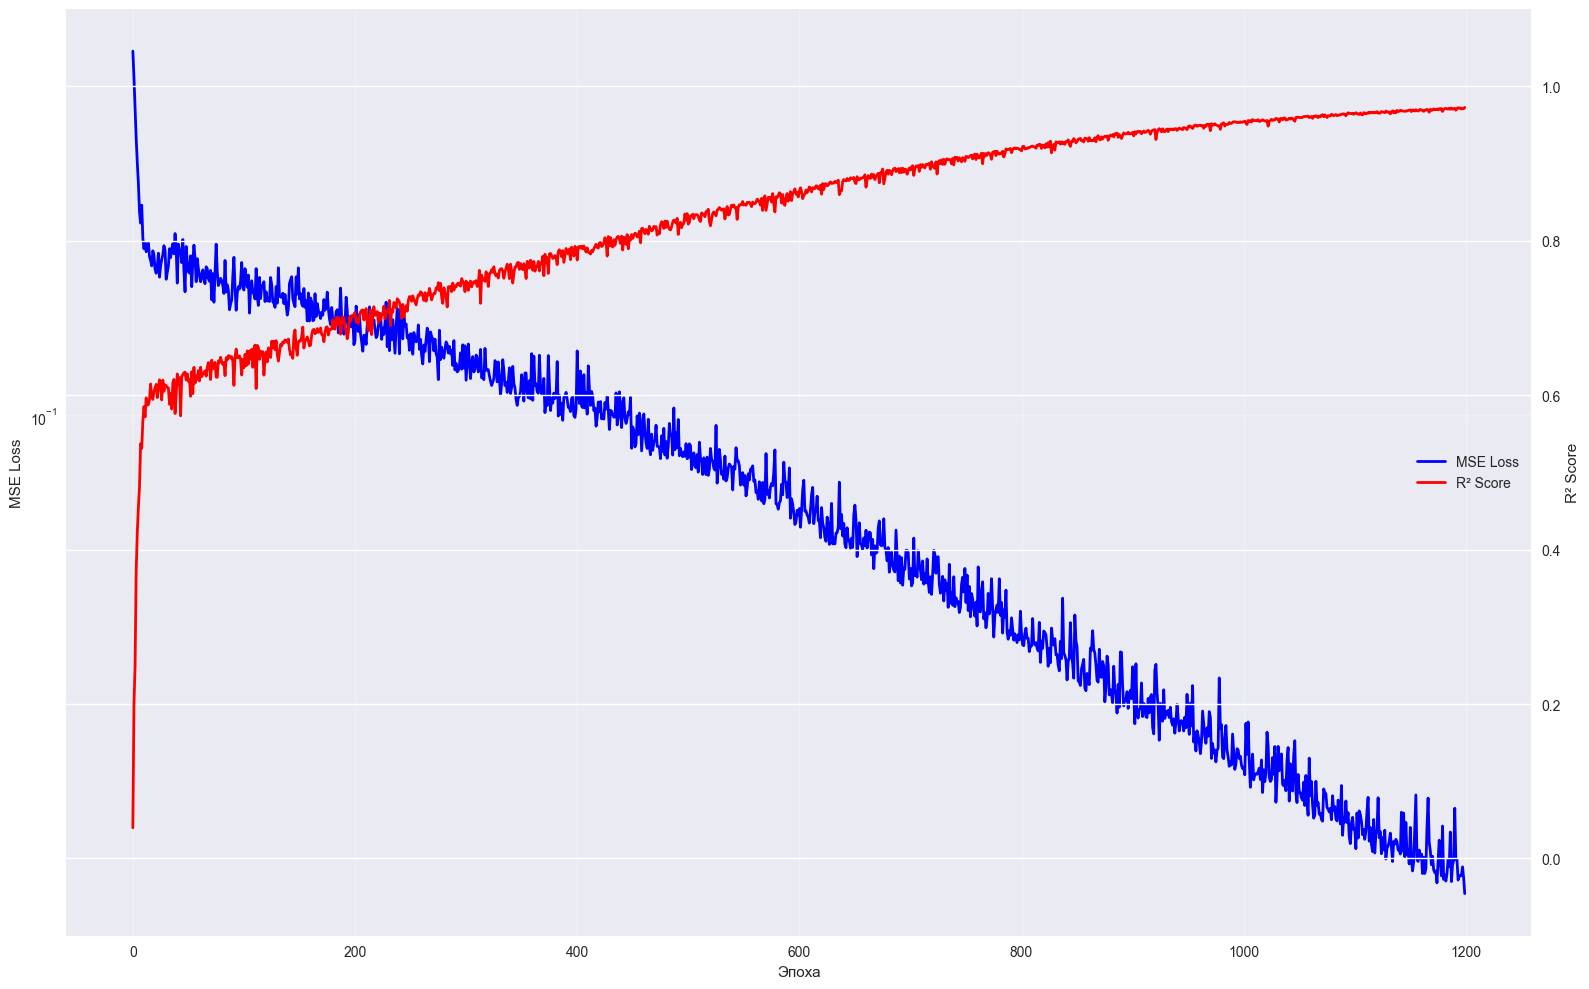

MSE Loss: 0.012943
Rˆ2 Score: 0.972514


In [342]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())


class SineModel(nn.Module):
    def __init__(self, n_features: int, n_hidden: int = 100, n_out: int = 1) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model = SineModel(n_features=1, n_hidden=100, n_out=1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

loss_metric = MeanMetric()  
r2_metric = R2Score()       

epoch_losses = []
epoch_r2_scores = []
predictions_history = []
epochs_to_save = [0, 100, 300, 600, 900, 1199]

epochs = 1200

for epoch in range(epochs):
    loss_metric.reset()
    r2_metric.reset()
    
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_metric.update(loss)  # Автоматически усредняет по батчам
        r2_metric.update(y_pred, batch_y)
    
    # Расчет метрик на уровне эпохи
    epoch_loss = loss_metric.compute()
    epoch_r2 = r2_metric.compute()
    
    epoch_losses.append(epoch_loss.item())
    epoch_r2_scores.append(epoch_r2.item())
    
    if epoch in epochs_to_save:
        with torch.no_grad():
            y_pred_full = model(X)
            predictions_history.append((epoch, y_pred_full.clone(), epoch_loss.item(), epoch_r2.item()))
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch:4d}, Loss: {epoch_loss:.6f}, R²: {epoch_r2:.4f}')

plt.figure(figsize=(16, 10))

    
# График 2: Функция потерь и R² по эпохам
ax1 = plt.gca()
ax2 = ax1.twinx()

line1 = ax1.plot(epoch_losses, 'b-', label='MSE Loss', linewidth=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('MSE Loss')
ax1.tick_params(axis='y')
ax1.set_yscale('log')

line2 = ax2.plot(epoch_r2_scores, 'r-', label='R² Score', linewidth=2)
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='y')
ax2.set_ylim(-0.1, 1.1)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"MSE Loss: {epoch_loss:.6f}")
print(f"Rˆ2 Score: {epoch_r2:.6f}")


sine_model, sine_losses, sine_r2 = model, epoch_losses, epoch_r2_scores


Epoch    0, Loss: 0.539095, R²: -0.1049
Epoch  200, Loss: 0.194246, R²: 0.5980
Epoch  400, Loss: 0.210739, R²: 0.6010
Epoch  600, Loss: 0.208151, R²: 0.6042
Epoch  800, Loss: 0.186015, R²: 0.6060
Epoch 1000, Loss: 0.189172, R²: 0.6129


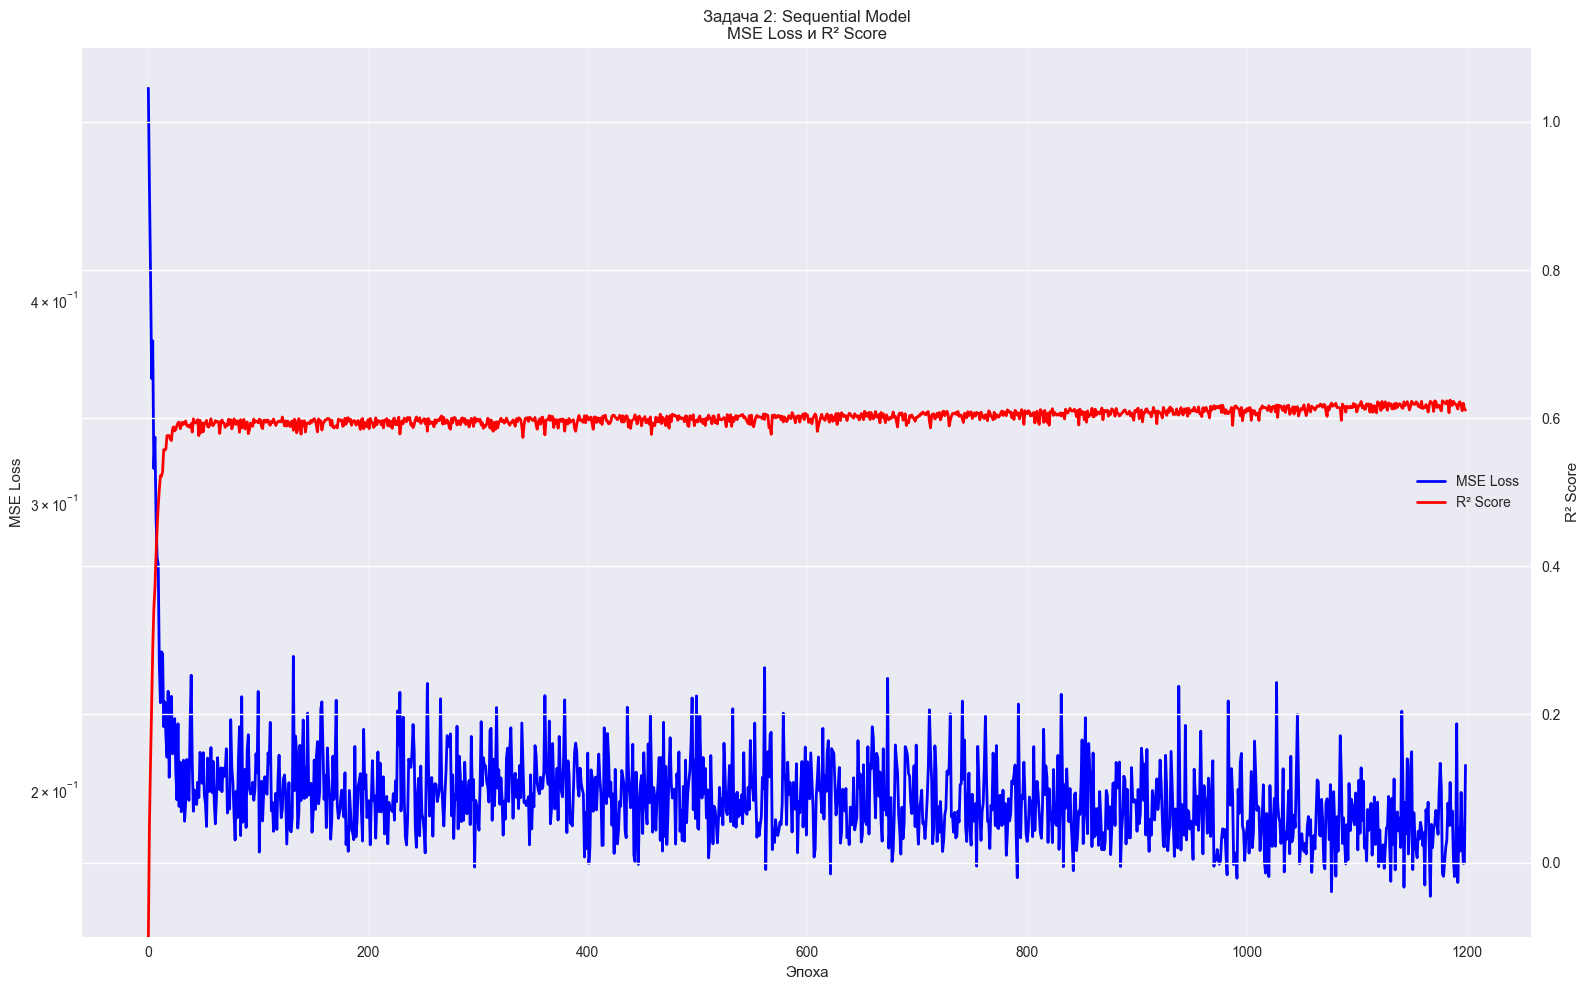

MSE: 0.207133
R²: 0.6109


In [350]:

model = nn.Sequential(
    nn.Linear(1, 50),    
    nn.Tanh(),          
    nn.Linear(50, 1)    
)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

loss_metric = MeanMetric()
r2_metric = R2Score()

epoch_losses = []
epoch_r2_scores = []

epochs = 1200

for epoch in range(epochs):
    loss_metric.reset()
    r2_metric.reset()
    
    for batch_X, batch_y in dataloader:
        y_pred = model(batch_X)
        loss = criterion(y_pred, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_metric.update(loss)
        r2_metric.update(y_pred, batch_y)
    
    epoch_loss = loss_metric.compute()
    epoch_r2 = r2_metric.compute()
    
    epoch_losses.append(epoch_loss.item())
    epoch_r2_scores.append(epoch_r2.item())
    
    if epoch % 200 == 0:
        print(f'Epoch {epoch:4d}, Loss: {epoch_loss:.6f}, R²: {epoch_r2:.4f}')

plt.figure(figsize=(16, 10))


ax1 = plt.gca()
ax2 = ax1.twinx()

line1 = ax1.plot(epoch_losses, 'b-', label='MSE Loss', linewidth=2)
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('MSE Loss')
ax1.tick_params(axis='y')
ax1.set_yscale('log')

line2 = ax2.plot(epoch_r2_scores, 'r-', label='R² Score', linewidth=2)
ax2.set_ylabel('R² Score')
ax2.tick_params(axis='y')
ax2.set_ylim(-0.1, 1.1)

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='center right')
ax1.grid(True, alpha=0.3)
plt.title('Задача 2: Sequential Model\nMSE Loss и R² Score')


plt.tight_layout()
plt.show()

print(f"MSE: {epoch_loss:.6f}")
print(f"R²: {epoch_r2:.4f}")
     
sequential_model, seq_losses, seq_r2 = model, epoch_losses, epoch_r2_scores
    

<p class="task" id="5"></p>

5\. Повторите решение задач 1-2, изменив функцию потерь. Обучите модель, используя три функции потерь: `MSELoss`, `L1Loss` и `HuberLoss` - и выведите на одном графике динамику изменения метрики $R^2$ по эпохам для каждой модели в процессе обучения. Добавьте подписи полученных кривых.

- [ ] Проверено на семинаре

In [364]:
torch.manual_seed(42)
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())


def train_model_with_loss_function(loss_function, loss_name, model_type='sine', 
                                  epochs=1200, learning_rate=0.01):
   
    if model_type == 'sine':
        model = nn.Sequential(
            nn.Linear(1, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
    else:  
        model = nn.Sequential(
            nn.Linear(1, 50),
            nn.Tanh(),
            nn.Linear(50, 1)
        )
    
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True)
    
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    r2_metric = R2Score()
    
    r2_scores = []
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0.0
        batch_count = 0
        
        r2_metric.reset()
        
        for batch_X, batch_y in dataloader:
            y_pred = model(batch_X)
            loss = loss_function(y_pred, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
            batch_count += 1
            
            r2_metric.update(y_pred, batch_y)
        
        avg_loss = epoch_loss / batch_count
        epoch_r2 = r2_metric.compute()
        
        losses.append(avg_loss)
        r2_scores.append(epoch_r2.item())
        
        if epoch % 400 == 0:
            print(f'{loss_name} - Epoch {epoch:4d}, Loss: {avg_loss:.6f}, R²: {epoch_r2:.4f}')
    
    final_r2 = r2_scores[-1]
    print(f'{loss_name} - Финальный R²: {final_r2:.4f}')
    
    return model, r2_scores, losses, final_r2

In [366]:
def compare_loss_functions_sine_model():
    
    loss_functions = {
        'MSE Loss': nn.MSELoss(),
        'L1 Loss': nn.L1Loss(),
        'Huber Loss': nn.HuberLoss(delta=0.5)  # delta - параметр перехода между L1 и L2
    }
    
    results = {}
    
    for loss_name, loss_fn in loss_functions.items():
        print(f"\n--- Обучение с {loss_name} ---")
        model, r2_scores, losses, final_r2 = train_model_with_loss_function(
            loss_fn, loss_name, model_type='sine', epochs=1200
        )
        results[loss_name] = {
            'r2_scores': r2_scores,
            'losses': losses,
            'final_r2': final_r2,
            'model': model
        }
    
    visualize_comparison(results, "SineModel")
    
    return results


--- Обучение с MSE Loss ---
MSE Loss - Epoch    0, Loss: 0.489062, R²: 0.0088
MSE Loss - Epoch  400, Loss: 0.107336, R²: 0.7758
MSE Loss - Epoch  800, Loss: 0.056650, R²: 0.8895
MSE Loss - Финальный R²: 0.9572

--- Обучение с L1 Loss ---
L1 Loss - Epoch    0, Loss: 0.692779, R²: -0.1601
L1 Loss - Epoch  400, Loss: 0.228895, R²: 0.8084
L1 Loss - Epoch  800, Loss: 0.102092, R²: 0.9642
L1 Loss - Финальный R²: 0.9726

--- Обучение с Huber Loss ---
Huber Loss - Epoch    0, Loss: 0.193816, R²: 0.0282
Huber Loss - Epoch  400, Loss: 0.071010, R²: 0.6850
Huber Loss - Epoch  800, Loss: 0.055883, R²: 0.7832
Huber Loss - Финальный R²: 0.8646


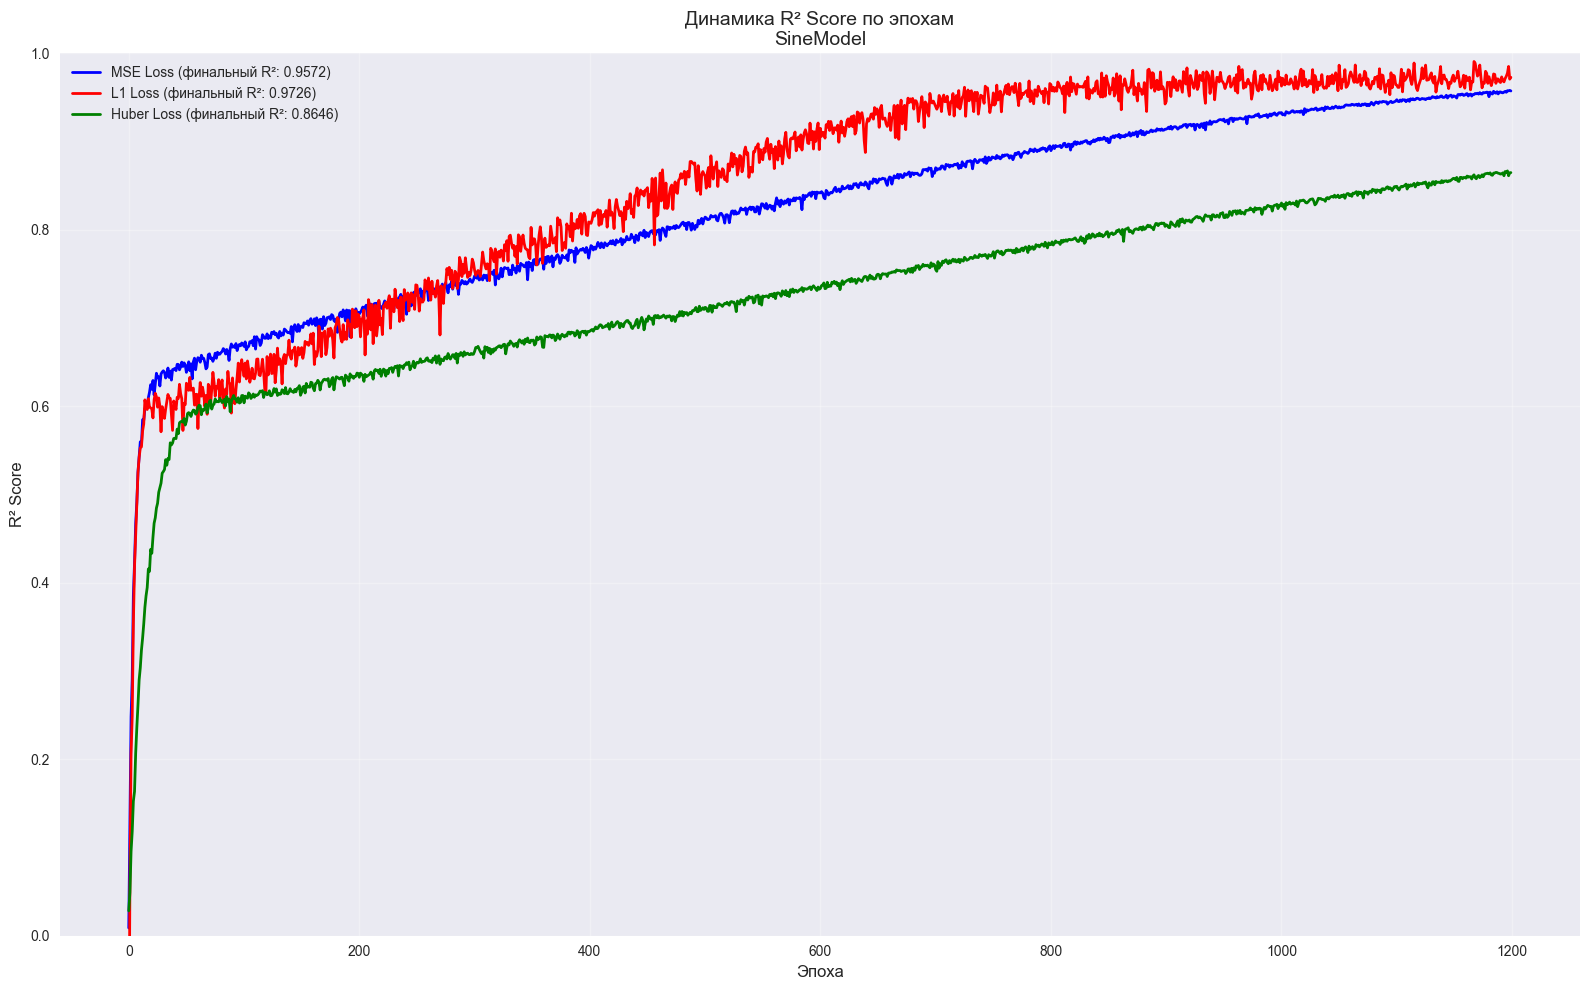


--- Обучение с MSE Loss ---
MSE Loss - Epoch    0, Loss: 0.638430, R²: -0.2592
MSE Loss - Epoch  400, Loss: 0.195421, R²: 0.6021
MSE Loss - Epoch  800, Loss: 0.185377, R²: 0.6089
MSE Loss - Финальный R²: 0.6144

--- Обучение с L1 Loss ---
L1 Loss - Epoch    0, Loss: 0.669117, R²: -0.0646
L1 Loss - Epoch  400, Loss: 0.404969, R²: 0.5703
L1 Loss - Epoch  800, Loss: 0.409018, R²: 0.5778
L1 Loss - Финальный R²: 0.5951

--- Обучение с Huber Loss ---
Huber Loss - Epoch    0, Loss: 0.236446, R²: -0.1947
Huber Loss - Epoch  400, Loss: 0.100485, R²: 0.5945
Huber Loss - Epoch  800, Loss: 0.093096, R²: 0.5956
Huber Loss - Финальный R²: 0.6048


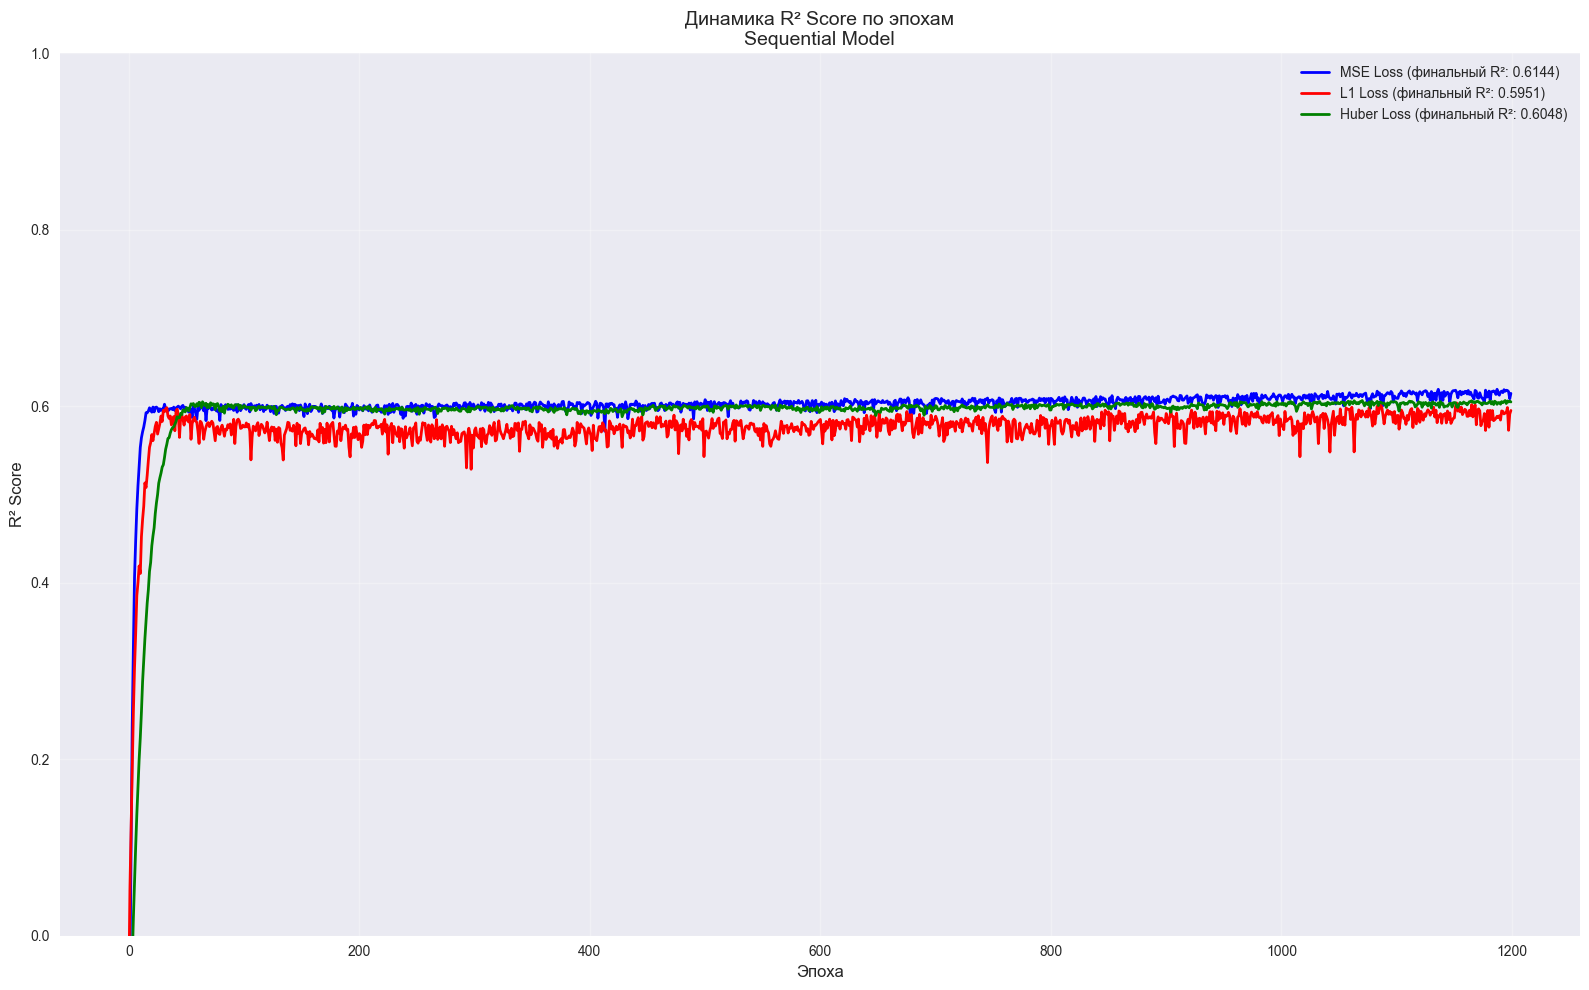

In [368]:
def compare_loss_functions_sequential_model():
    
    loss_functions = {
        'MSE Loss': nn.MSELoss(),
        'L1 Loss': nn.L1Loss(),
        'Huber Loss': nn.HuberLoss(delta=0.5)
    }
    
    results = {}
    
    for loss_name, loss_fn in loss_functions.items():
        print(f"\n--- Обучение с {loss_name} ---")
        model, r2_scores, losses, final_r2 = train_model_with_loss_function(
            loss_fn, loss_name, model_type='sequential', epochs=1200
        )
        results[loss_name] = {
            'r2_scores': r2_scores,
            'losses': losses,
            'final_r2': final_r2,
            'model': model
        }
    visualize_comparison(results, "Sequential Model")
    
    return results

def visualize_comparison(results, title):
    
    plt.style.use('seaborn-v0_8')
    fig, ax1 = plt.subplots(figsize=(16, 10))
    
    colors = {'MSE Loss': 'blue', 'L1 Loss': 'red', 'Huber Loss': 'green'}
    
    for loss_name, data in results.items():
        r2_scores = data['r2_scores']
        ax1.plot(r2_scores, 
                color=colors[loss_name], 
                linewidth=2,
                label=f'{loss_name} (финальный R²: {data["final_r2"]:.4f})')
    
    ax1.set_xlabel('Эпоха', fontsize=12)
    ax1.set_ylabel('R² Score', fontsize=12)
    ax1.set_title(f'Динамика R² Score по эпохам\n{title}', fontsize=14)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()
    
results_sine = compare_loss_functions_sine_model()

results_sequential = compare_loss_functions_sequential_model()


<p class="task" id="6"></p>

6\. Повторите решение задач 1-2, разделив датасет на обучающую и тестовую выборку в соотношении 80% на 20%. Обучите модель. Для тестовой выборки посчитайте и выведите на экран значения метрик:

- MAE;
- MAPE;
- MSE;
- MSLE (MeanSquaredLogError).
 

- [ ] Проверено на семинаре

In [412]:
from sklearn.model_selection import train_test_split 


X = torch.linspace(0, 1, 200).view(-1, 1)  
y = torch.sin(2 * torch.pi * X) + 0.1 * torch.rand(X.size())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)


class SineModel(nn.Module):
    def __init__(self, n_features: int = 1, n_hidden: int = 100, n_out: int = 1):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

def create_sequential_model():
    return nn.Sequential(
        nn.Linear(1, 50),
        nn.Tanh(),
        nn.Linear(50, 1)
    )


def train_model_with_validation(model, train_dataset, test_dataset, 
                              epochs=1200, learning_rate=0.01, model_name="Model"):

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    train_r2_metric = R2Score()
    
    train_losses = []
    test_losses = []
    train_r2_scores = []
    test_r2_scores = []
    
    print(f"\n--- Обучение {model_name} ---")
    
    for epoch in range(epochs):
        model.train()
        epoch_train_loss = 0.0
        batch_count = 0
        
        train_r2_metric.reset()
        
        for batch_X, batch_y in train_loader:
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            epoch_train_loss += loss.item()
            batch_count += 1
            train_r2_metric.update(y_pred, batch_y)
        
        avg_train_loss = epoch_train_loss / batch_count
        train_r2 = train_r2_metric.compute()
        
        model.eval()
        with torch.no_grad():
            test_X, test_y = next(iter(test_loader))
            test_pred = model(test_X)
            test_loss = criterion(test_pred, test_y)
            test_r2 = R2Score()(test_pred, test_y)
        

        train_losses.append(avg_train_loss)
        test_losses.append(test_loss.item())
        train_r2_scores.append(train_r2.item())
        test_r2_scores.append(test_r2.item())
        
        if epoch % 300 == 0:
            print(f'Epoch {epoch:4d}, Train Loss: {avg_train_loss:.6f}, '
                  f'Test Loss: {test_loss.item():.6f}, '
                  f'Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}')
    
    final_train_r2 = train_r2_scores[-1]
    final_test_r2 = test_r2_scores[-1]
    print(f'{model_name} - Финальные метрики:')
    print(f'  Train R²: {final_train_r2:.4f}, Test R²: {final_test_r2:.4f}')
    
    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2_scores': train_r2_scores,
        'test_r2_scores': test_r2_scores,
        'final_train_r2': final_train_r2,
        'final_test_r2': final_test_r2
    }


def calculate_test_metrics(model, test_dataset, model_name="Model"):
    model.eval()
    test_loader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)
    
    with torch.no_grad():
        test_X, test_y = next(iter(test_loader))
        test_pred = model(test_X)
      
        mae_metric = MeanAbsoluteError()
        mape_metric = MeanAbsolutePercentageError()
        mse_metric = MeanSquaredError()
        msle_metric = MeanSquaredLogError()
        r2_metric = R2Score()
        
        mae = mae_metric(test_pred, test_y)
        mape = mape_metric(test_pred, test_y)
        mse = mse_metric(test_pred, test_y)
        msle = msle_metric(test_pred, test_y)
        r2 = r2_metric(test_pred, test_y)
        
        print(f"\n=== МЕТРИКИ {model_name} НА ТЕСТОВОЙ ВЫБОРКЕ ===")
        print(f"MAE  (Mean Absolute Error):           {mae:.6f}")
        print(f"MAPE (Mean Absolute Percentage Error): {mape:.6f}")
        print(f"MSE  (Mean Squared Error):            {mse:.6f}")
        print(f"MSLE (Mean Squared Log Error):        {msle:.6f}")
        print(f"R²   (R-squared):                     {r2:.4f}")
        
        return {
            'MAE': mae.item(),
            'MAPE': mape.item(),
            'MSE': mse.item(),
            'MSLE': msle.item(),
            'R2': r2.item(),
            'predictions': test_pred,
            'targets': test_y
        }




sine_model = SineModel()
results_sine = train_model_with_validation(
    sine_model, train_dataset, test_dataset, 
    model_name="SineModel"
)
results_metrics = calculate_test_metrics(sine_model, test_dataset, model_name="SineModel")


sequential_model = create_sequential_model()
results_sequential = train_model_with_validation(
    sequential_model, train_dataset, test_dataset,
    model_name="Sequential Model"
)
results_metrics = calculate_test_metrics(sequential_model, test_dataset, model_name="Sequential Model")




--- Обучение SineModel ---
Epoch    0, Train Loss: 0.411968, Test Loss: 0.518608, Train R²: 0.1305, Test R²: 0.0472
Epoch  300, Train Loss: 0.147748, Test Loss: 0.146782, Train R²: 0.6882, Test R²: 0.7303
Epoch  600, Train Loss: 0.109315, Test Loss: 0.106826, Train R²: 0.7693, Test R²: 0.8037
Epoch  900, Train Loss: 0.076776, Test Loss: 0.073393, Train R²: 0.8380, Test R²: 0.8652
SineModel - Финальные метрики:
  Train R²: 0.8954, Test R²: 0.9250

=== МЕТРИКИ SineModel НА ТЕСТОВОЙ ВЫБОРКЕ ===
MAE  (Mean Absolute Error):           0.181898
MAPE (Mean Absolute Percentage Error): 0.451279
MSE  (Mean Squared Error):            0.040825
MSLE (Mean Squared Log Error):        0.420251
R²   (R-squared):                     0.9250

--- Обучение Sequential Model ---
Epoch    0, Train Loss: 0.446274, Test Loss: 0.538646, Train R²: 0.0581, Test R²: 0.0104
Epoch  300, Train Loss: 0.193709, Test Loss: 0.212227, Train R²: 0.5912, Test R²: 0.6101
Epoch  600, Train Loss: 0.191555, Test Loss: 0.206527, 